For our project we would be using Hyperopt, which is one of the several automated hyperparameter tuning libraries using Bayesian optimization. Hyperopt uses Tree Parzen Estimator(TPE).
Hyperopt has a simple syntax for structuring an optimization problem, which extends beyond hyperparameter tuning to any problem that involves minimizing a function. 

Objective of the Project
we will optimize the hyperparameters of a Gradient Boosting Machine using the Hyperopt library (with the Tree Parzen Estimator algorithm). We will compare the results of random search (implemented manually) for hyperparameter tuning with the Bayesian model-based optimization method to try and understand how the Bayesian method works and what benefits it has over uninformed search methods.

In [76]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import KFold

MAX_EVALS = 500
N_FOLDS = 10

DATASET

For experimentation, we have taken the Caravan Insurance Challenge data (https://www.kaggle.com/datasets/uciml/caravan-insurance-challenge?resource=download) 

We aim to determine whether or not a potential customer will buy an insurance policy by training a model on past data. We want to train a model to predict a binary outcome on testing data. (Supervised Classification) 

In [3]:
#Load the data and split into Train and Test, the dataset already defines Test and Train in the 'ORIGIN' 
data = pd.read_csv(r'C:\Users\obero\Desktop\RUTGERS\Projects\Bayesian-Hyperparameter-Optimization\data\caravan-insurance-challenge.csv')

train = data[data['ORIGIN']=='train']
test = data[data['ORIGIN']=='test']

data.info()
train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,))
test_labels  = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,))

#data cleaning
train = train.drop(columns = ['ORIGIN','CARAVAN'])
test = test.drop(columns = ['ORIGIN','CARAVAN'])

#Conversion to numpy array for splitting in cross validation

features = np.array(train)
test_features = np.array(test)
labels = train_labels[:]

print('Train shape', train.shape)
print('Test shape',test.shape)
train.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9822 entries, 0 to 9821
Data columns (total 87 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ORIGIN    9822 non-null   object
 1   MOSTYPE   9822 non-null   int64 
 2   MAANTHUI  9822 non-null   int64 
 3   MGEMOMV   9822 non-null   int64 
 4   MGEMLEEF  9822 non-null   int64 
 5   MOSHOOFD  9822 non-null   int64 
 6   MGODRK    9822 non-null   int64 
 7   MGODPR    9822 non-null   int64 
 8   MGODOV    9822 non-null   int64 
 9   MGODGE    9822 non-null   int64 
 10  MRELGE    9822 non-null   int64 
 11  MRELSA    9822 non-null   int64 
 12  MRELOV    9822 non-null   int64 
 13  MFALLEEN  9822 non-null   int64 
 14  MFGEKIND  9822 non-null   int64 
 15  MFWEKIND  9822 non-null   int64 
 16  MOPLHOOG  9822 non-null   int64 
 17  MOPLMIDD  9822 non-null   int64 
 18  MOPLLAAG  9822 non-null   int64 
 19  MBERHOOG  9822 non-null   int64 
 20  MBERZELF  9822 non-null   int64 
 21  MBERBOER  9822

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0


Distribution of Labels

Text(0.5, 1.0, 'Count of Labels')

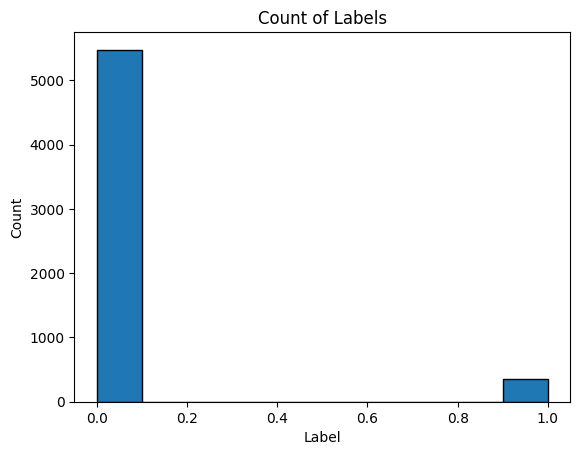

In [4]:
import matplotlib.pyplot as plt

plt.hist(labels,edgecolor='k')
plt.xlabel('Label')
plt.ylabel("Count")
plt.title("Count of Labels")

We can observe an imbalanced class problem, There are more observations where an insurance policy was not bought(0) than when the policy was bought(1). Therefore, accuracy is a poor metric to use for this task. Instead, we will use the common classification metric of Receiver Operating Characteristic Area Under the Curve (ROC AUC). Randomly guessing on a classification problem will yield an ROC AUC of 0.5 and a perfect classifier has an ROC AUC of 1.0. For a better baseline model than random guessing, we can train a default Gradient Boosting Machine and have it make predictions.

In [5]:
#Default GBM i.e. model with default hyperparameters

model = lgb.LGBMClassifier()
param = model.get_params()
param

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [6]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer
start = timer()
model.fit(features,labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:,1]
auc = roc_auc_score(test_labels,predictions)

print("the baseline score on the test set is {:.4f}.".format(auc))
print("the baseline training time is {:.4f} seconds ".format(train_time))

[LightGBM] [Info] Number of positive: 348, number of negative: 5474
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 5822, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.059773 -> initscore=-2.755562
[LightGBM] [Info] Start training from score -2.755562
the baseline score on the test set is 0.7089.
the baseline training time is 0.2539 seconds 


We have to beat the baseline metric. Due to the small size of the dataset, hyperparameter tuning will have a modest but noticeable effect on the performance.

Lets start with Hyperparameter tuning 
 
First we will implement a common technique for hyperparameter optimization: random search. Each iteration, we choose a random set of model hyperparameters from a search space.

Random search uses the following four parts, which are also used in Bayesian hyperparameter optimization:

1.Domain: values over which to search

2.Optimization : pick the next values at random

3.Objective function to minimize: in this case our metric is cross validation ROC AUC

4.Results history that tracks the hyperparameters tried and the cross validation metric

Random search can be implemented in the scikit-learn library using RandomizedSearchCV, However because we are using Early stopping(to determine the optimal number of estimators), we will implement the method.

In [7]:
import random

Random Search and Bayesian optimization both search for hyperparameters from a domain. For random(or grid search) this domain is called as hyperparameter grid and uses discrete values for the hyperparameters.

In [8]:
param

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Explanation of Parameters in the param_grid (Source - ChatGPT)
class_weight: Used to handle imbalanced data. It adjusts weights inversely proportional to class frequencies in the input data. Possible values are:

None: All classes have equal weights.
balanced: Automatically adjust weights inversely proportional to class frequencies.
boosting_type: Specifies the type of algorithm to use:

gbdt: Traditional Gradient Boosting Decision Tree.
goss: Gradient-based One-Side Sampling.
dart: Dropouts meet Multiple Additive Regression Trees.
num_leaves: Number of leaves in each tree. More leaves will increase the model complexity and can lead to overfitting.

learning_rate: Controls the impact of each tree on the final outcome. Lower rates mean more trees are needed to model all relations and will be more robust to overfitting.

subsample_for_bin: Number of samples for constructing bins. Using smaller bins may provide faster performance but might lead to overfitting.

min_child_samples: Minimum number of data points needed in a child (leaf). Used to control over-fitting. Higher numbers prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.

reg_alpha (L1 regularization): Regularization term on weights. Can be used for feature selection by driving coefficients of less important features to zero.

reg_lambda (L2 regularization): Regularization term on weights. Smooths the weights to avoid overfitting, penalizing weights that are too large.

colsample_bytree: The fraction of features to be used for each tree. A smaller value can lead to faster training and prevents overfitting.

In [10]:
# Hyperparameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

# Subsampling (only applicable with 'goss')
subsample_dist = list(np.linspace(0.5, 1, 100))

The learning rate is represented by the logarithmic distribution because it can vary over several orders of magnitude.

Text(0.5, 1.0, 'Learning Rate Distribution')

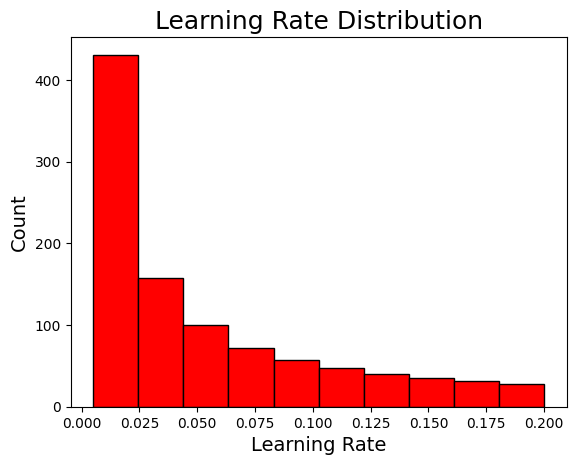

In [11]:
# Plotting the learning rate

plt.hist(param_grid['learning_rate'], color = 'red', edgecolor = 'black')
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18)

We can observe that smaller values of the learning rate are more common with the values between 0.005 and 0.200

We can also observe that the width of the domain seems to be wide and we are uncertain about the optimal value.

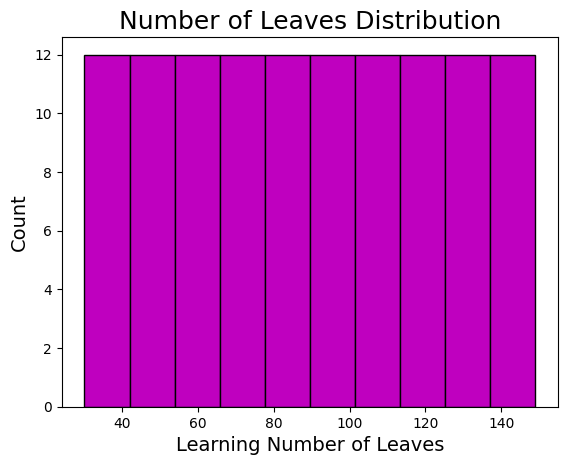

In [12]:
# plot the leaves and check for its distribution

plt.hist(param_grid['num_leaves'], color = 'm', edgecolor = 'k')
plt.xlabel('Learning Number of Leaves', size = 14); plt.ylabel('Count', size = 14); plt.title('Number of Leaves Distribution', size = 18);

The leaves are uniform in nature.

In [26]:
#The next task is to sample the set of hyperparameters from the grid using a dictionary comprehension
params = {key: random.sample(value,1)[0] for key, value in param_grid.items()}
params

{'class_weight': None,
 'boosting_type': 'dart',
 'num_leaves': 32,
 'learning_rate': 0.03824623403550541,
 'subsample_for_bin': 60000,
 'min_child_samples': 45,
 'reg_alpha': 0.42857142857142855,
 'reg_lambda': 0.8979591836734693,
 'colsample_bytree': 1.0}

If the boosting_type is not goss, add a subsample

In [55]:
params['subsample'] = random.sample(subsample_dist,1)[0] if params ['boosting_type']!='goss' else 1.0
params

{'class_weight': None,
 'boosting_type': 'dart',
 'num_leaves': 32,
 'learning_rate': 0.03824623403550541,
 'subsample_for_bin': 60000,
 'min_child_samples': 45,
 'reg_alpha': 0.42857142857142855,
 'reg_lambda': 0.8979591836734693,
 'colsample_bytree': 1.0,
 'subsample': 0.9646464646464648}

The subsample is set to 1.0 if the boosting type is goss which is equivalent to not using any subsampling.

Cross Validation with Early stopping in LightGBM. 

Why is early stopping used?(Source Chatgpt)

Early stopping is a form of regularization used to avoid overfitting when training a machine learning model, particularly in the context of iterative algorithms like those used in training deep neural networks or gradient boosting models. Here’s why early stopping is important in the context of cross-validation:

Prevent Overfitting: One of the primary reasons to use early stopping is to prevent the model from overfitting. Overfitting occurs when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. By stopping the training process once the model's performance ceases to improve (or begins to degrade) on a held-out validation dataset, you can ensure the model maintains a general capability to perform well on unseen data.

Optimize Training Time: Early stopping helps in reducing unnecessary training time by stopping the training process once further training no longer leads to better results on the validation set. This makes the training process more efficient by not wasting resources.

Model Selection: In cross-validation, particularly when using techniques like k-fold cross-validation, early stopping can be used to select the iteration or model that performs the best on the validation data, not merely the last iteration. This helps in selecting a model that strikes the right balance between bias and variance.



In [64]:
#Create a lgb dataset, that is suitable for training lightGBM models.

train_set = lgb.Dataset(features,label=labels)

In [97]:
#Perform cross validation with 10 folds
r = lgb.cv(
    params=params,
    train_set=train_set,
    num_boost_round=1000,
    nfold=10,
    metrics='auc',
    callbacks=[lgb.callback.early_stopping(stopping_rounds=100, verbose=False)], 
    seed=50
)
# Correct the keys for mean and standard deviation of AUC
r_best = np.max(r['valid auc-mean'])
r_best_std = r['valid auc-stdv'][np.argmax(r['valid auc-mean'])]

print('The maximum ROC AUC on the validation set was {:.5f} with std of {:.5f}.'.format(r_best, r_best_std))
print('The ideal number of iterations was {}.'.format(np.argmax(r['valid auc-mean']) + 1))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 5239, number of used features: 71
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 5239, number of used features: 71
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points

c:\Users\obero\Desktop\RUTGERS\Projects\Bayesian-Hyperparameter-Optimization\venv\Lib\site-packages\lightgbm\callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


The maximum ROC AUC on the validation set was 0.73838 with std of 0.03531.
The ideal number of iterations was 18.


Result Dataframe

In [98]:
# Dataframe to hold cv results, Use this dataframe to compare the different results obtained from different techniques
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))

In [100]:
random_results

,loss,params,iteration,estimators,time
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
495,NaN,NaN,NaN,NaN,NaN
496,NaN,NaN,NaN,NaN,NaN
497,NaN,NaN,NaN,NaN,NaN
498,NaN,NaN,NaN,NaN,NaN


Objective Function

we will take in the hyperparameters and return the validation loss. 

In the case of random search, the next values selected are not based on the past evaluation results.

In [105]:
def random_objective(params,iteration,n_folds = N_FOLDS):
    
    start = timer()
    cv_results = lgb.cv(params=params,train_set=train_set,num_boost_round=1000,nfold=n_folds, metrics='auc',
    callbacks=[lgb.callback.early_stopping(stopping_rounds=100, verbose=False)], 
    seed=50)
    end  = timer()
    best_score = np.max(cv_results['valid auc-mean'])
    
    loss = 1 - best_score
    
    n_estimators = int(np.argmax(cv_results['valid auc-mean']) + 1)
    
    return [loss,params,iteration,n_estimators,end - start]

Random Search Implementation

In [114]:
%%capture

random.seed(50)

# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    print(params)
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]
        
        
    results_list = random_objective(params, i)
    
    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

LightGBMError: Cannot change bin_construct_sample_cnt after constructed Dataset handle.

In [103]:
random_results.sort_values('loss',ascending=True,inplace=True)
random_results.sort_values(inplace=True,drop = True)
random_results.head()


TypeError: DataFrame.sort_values() got an unexpected keyword argument 'drop'

In [109]:
cv_results = lgb.cv(...)
print(cv_results.keys())



TypeError: cv() missing 1 required positional argument: 'train_set'